# Introduction
We hope you're reading this on <font color = "orange">Google Colab</font>. If not, go back to Part III and follow the guide! 

In this section, we will:
1. Mount the Google Drive and read the CSV
2. Train a vanilla LSTM model using Open
3. Train another vanilla LSTM model using FilteredOpen
4. Plot and compare our model results

As mentioned at the end of Part I, we will be answering two questions:
1. Can LSTM help with stock predictions?
2. Can using signal processing technique help with improving stock predictions?

### Step 1: Import pandas
Let's start with importing pandas.

In [1]:
# Step 1: Import pandas
import pandas as pd

### Step 2: Mount your drive
Before we can read the CSV we'll need to mount the drive.

![MountDriveInstructions](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/MountDriveInstructions.png)

Steps you'll need:
1. Connect the runtime
2. Mount your Google Drive
3. Navigate through your directory until you reach the folder containing "Project Finance x LSTM (Part IV).ipynb" and the CSV from Part III
4. [Not shown] Right click, and click 'Copy path'
5. Use that to read your CSV using pandas later

In [2]:
# Step 2: Click on 'Mount Drive' button (2) and mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 3: Read the CSV from Part III
Now that you've mounted the Drive, you can now read the CSV that you've uploaded into the Google Drive.

Make sure you set the first column as your index, and parse dates so that the dates are parsed as DateTimeIndex object.

You should have:
- 4,904 rows
- 7 columns

In [3]:
# Step 3: Read the CSV from Part III
df=pd.read_csv('/content/drive/MyDrive/Project Finance x LSTM/yfinanace_v0.2.csv', parse_dates=['Date'], index_col='Date')
df

,Open,High,Low,Close,Adj Close,Volume,FilteredOpen
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1509.891113
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1460.423078
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1438.658516
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1386.279016
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1399.262688
...,...,...,...,...,...,...,...
2019-06-25,2945.780029,2946.520020,2916.010010,2917.379883,2917.379883,3578050000,2911.075968
2019-06-26,2926.070068,2932.590088,2912.989990,2913.780029,2913.780029,3478130000,2913.774021
2019-06-27,2919.659912,2929.300049,2918.570068,2924.919922,2924.919922,3122920000,2913.647693


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4904 entries, 2000-01-03 to 2019-07-01
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4904 non-null   float64
 1   High          4904 non-null   float64
 2   Low           4904 non-null   float64
 3   Close         4904 non-null   float64
 4   Adj Close     4904 non-null   float64
 5   Volume        4904 non-null   int64  
 6   FilteredOpen  4904 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 306.5 KB


### Step 4: Import libraries
Now, we import the rest of the libraries needed for LSTM model training. Here are the libraries you'll need:
- matplotlib.pyplot as plt
- numpy as np
- StandardScaler from sklearn.preprocessing
- mean_squared_error from sklearn.metrics
- Sequential from keras.models
- Dense from keras.layers
- LSTM from keras.layers
- Dropout from keras.layers

In [5]:
# Step 4: Import libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

### Step 5: Split your data into train and test
Similarly, split your DataFrame into train and test DataFrames according to the following dates:

- Train data: January 3 2000 to May 16 2019
- Test data: May 15 2019 to July 1 2019

You might be wondering why there's an overlap between the last 2 days and first 2 days of Train and Test respectively. 

We'll explain a bit more later.

In [6]:
# Step 5: Split DataFrame into train and test
TrainD=df.loc['2000-01-03':'2019-05-16']
TestD=df.loc['2019-05-15':'2019-07-01']

# Data Preparation
We'll have to do a bit more data preparation before we start training our model.

This step was not mentioned in the publication, but it's good practice to scale your values. 

We'll prepare three separate sets of scaled training data:
1. Open
2. FilteredOpen
3. ZeroMeanFilteredOpen (we'll get to that soon)

### Step 6: Add a new column called ZeroMeanFilteredOpen
![ResearchPaperNormalization](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ResearchPaperNormalization.png)

In the paper, the authors performed zero-mean normalization. What is zero-mean normalization?

![ZeroMeanNormalization](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/ZeroMeanNormalization.png)

Zero-mean normalization happens when you subtract all values in a column with the overall mean. 

We will do the same with our denoised Open data and name the new column 'ZeroMeanFilteredOpen'.

Here's what we'll do:
1. Create a new column 'ZeroMeanFilteredOpen' in the train DataFrame, using the mean of 'FilteredOpen' in train
2. Create a new column 'ZeroMeanFilteredOpen' in the test DataFrame, using the mean of 'FilteredOpen' in train

It's not the usual normalization, but we should still normalize after splitting, and using data from train set only.

In [7]:
# Step 6a: Get the mean of 'FilteredOpen' from train
m=np.mean(TrainD['FilteredOpen'].values)

# Step 6b: Create 'ZeroMeanFilteredOpen' in train
TrainD['ZeroMeanFilteredOpen']=TrainD['FilteredOpen']-m

# Step 6c: Create 'ZeroMeanFilteredOpen' in test
TestD['ZeroMeanFilteredOpen']=TestD['FilteredOpen']-m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Step 7: Transform Open, FilteredOpen, and ZeroMeanFilteredOpen with StandardScaler
After creating ZeroMeanFilteredOpen, we'll proceed with feature scaling. 

This step was not mentioned in the paper, but it's good practice to do so for training. 

First, let's declare three variables containing a StandardScaler, without any additional parameters. 

We can't use the same scaler for the three Opens because we'll be using the scaler to un-scale predictions as well so the scaler properties must be specific to each Open data.

Then, we'll scale our column values and use that for training.

Note: If you have an error that goes <strong>"Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample."</strong>, you used a Series. 

Either use a DataFrame containing only the Open/FilteredOpen/ZeroMeanFilteredOpen column, or a (-1, 1) reshape to reshape your the np.array of your Series.

In [8]:
# Step 7a: Declare a StandardScaler for Open
OpenScaler=StandardScaler()

# Step 7b: Call .fit_transform on the 'Open' column values from your train dataset
OpenScaled=OpenScaler.fit_transform(TrainD[['Open']])

# Step 7c: Declare a StandardScaler for FilteredOpen
FOScaler=StandardScaler()

# Step 7d: Call .fit_transform on the 'FilteredOpen' column values from your train dataset
FOScaled=FOScaler.fit_transform(TrainD[['FilteredOpen']])

# Step 7e: Declare a StandardScaler for ZeroMeanFilteredOpen
ZMFOScaler=StandardScaler()

# Step 7f: Call .fit_transform on the 'ZeroMeanFilteredOpen' column values from your train dataset
ZMFOScaled=ZMFOScaler.fit_transform(TrainD[['ZeroMeanFilteredOpen']])

### Step 8: Prepare create arrays for training
A bit of context on why we're creating more arrays. For LSTM, we're taking a sequence of data and predicting an output in the end. 

In our case, we're taking a window of two prices in sequence, and predicting the next one.

![LSTMTrainingWindow](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LSTMTrainingWindow.png)

This is why we had the small overlap - so that we have enough data to predict for the "first" day of our test data, which the authors said was 17th May 2019.

<strong>You will create a list of length-2 NumPy arrays for your train data, and a NumPy array of prices for your test data.</strong>

Something like this for the scaled 'Open':

![OpenXyTrainList](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenXyTrainList.png)

Expect six variables after running this step. Three sets of X train lists and y train lists for "Open", "FilteredOpen", and "ZeroMeanFilteredOpen".

<details>
    <summary>Click for instructions if you're stuck</summary>
    <div>
        <ol>
            <li>Declare list for X train</li>
            <li>Declare list for y train</li>
            <li>Loop through your scaled "Open" values using a for loop and range function</li>
              <ul>
                  <li>Start at index 2 and end at the last index, so you'll need to configure your range</li>
                  <li>Append your X train list with an array containing items from 1 and 2 indices before, i.e. if I am at index 2, I should be appending a NumPy array containing items from index 0 and 1</li>
                  <li>Append your y train list with the item from the current index</li>
              </ul>
            <li>Don't forget that the scaled values from Step 7 are in a NumPy array as well so you need to reshape your sliced array</li>
        </ol>
    </div>
    <div>
        <p>Tweak the values around like [i-2:i, y] as your slicing (figure what y is and you'll be fine)</p>
    </div>
</details>



In [9]:
# Step 8a: Prepare X train and y train using scaled "Open"
X_Open_train=[]
y_Open_train=[]
for i in range(2,len(OpenScaled)):
  X_Open_train.append(OpenScaled[i-2:i,0])
  y_Open_train.append(OpenScaled[i,0])

# Step 8b: Prepare X train and y train using scaled "FilteredOpen"
X_FO_train=[]
y_FO_train=[]
for i in range(2,len(FOScaled)):
  X_FO_train.append(FOScaled[i-2:i,0])
  y_FO_train.append(FOScaled[i,0])

# Step 8c: Prepare X train and y train using scaled "ZeroMeanFilteredOpen"
X_ZMFO_train=[]
y_ZMFO_train=[]
for i in range(2,len(ZMFOScaled)):
  X_ZMFO_train.append(ZMFOScaled[i-2:i,0])
  y_ZMFO_train.append(ZMFOScaled[i,0])

### Step 9: Turn the X train and y train lists into NumPy arrays
Now that you have a list of NumPy arrays, time to turn them into a NumPy array of NumPy arrays.

Sounds confusing, we know. That's why we had this as a separate instruction.

After you turn the list into a NumPy array, you can look at its .shape attribute and get a (4871,2) for train, and (4871,) for test.

<details>
    <summary>Click once if you need a hint</summary>
    <div>
        <strong>Google "convert python list into numpy array"</strong>
    </div>
</details>

In [10]:
# Step 9a: Turn open X train list into NumPy array
X_Open_train=np.array(X_Open_train)

# Step 9b: Turn open y train list into NumPy array
y_Open_train=np.array(y_Open_train)

# Step 9a: Turn filtered X train list into NumPy array
X_FO_train=np.array(X_FO_train)

# Step 9b: Turn filtered y train list into NumPy array
y_FO_train=np.array(y_FO_train)

# Step 9a: Turn open X train list into NumPy array
X_ZMFO_train=np.array(X_ZMFO_train)

# Step 9b: Turn open y train list into NumPy array
y_ZMFO_train=np.array(y_ZMFO_train)

In [11]:
# Optional: Get the shape of your converted arrays
print(X_ZMFO_train.shape)
print(y_ZMFO_train.shape)

(4871, 2)
(4871,)


### Step 10: Reshape your X train NumPy arrays
We will now reshape our X train arrays from 2D to 3D.

Earlier on, you migth have found that our X train arrays have a shape of (4871, 2). Reshape it such that it becomes (4871, 2, 1), a 3D array.

In [12]:
'''
A LSTM network expects the input to be in the form [samples, time steps, features] 
where samples is the number of data points we have, time steps is the number of time-dependent steps 
that are there in a single data point, features refers to the number of variables 
we have for the corresponding true value in Y.
'''

# Step 10a: Reshape your "Open" X train array
X_Open_train=X_Open_train.reshape(X_Open_train.shape[0], X_Open_train.shape[1], -1)

# Step 10b: Reshape your "FilteredOpen" X train array
X_FO_train=X_FO_train.reshape(X_FO_train.shape[0], X_FO_train.shape[1], -1)

# Step 10c: Reshape your "ZeroMeanFilteredOpen" X train array
X_ZMFO_train=X_ZMFO_train.reshape(X_ZMFO_train.shape[0], X_ZMFO_train.shape[1], -1)

# Model building and prediction
Now that we've prepared our data, now is the time to build and train the model. Since the authors did not detail their architecture, we'll be using a simple LSTM model architecture in this exercise. 

Don't worry, it does its job well.

### Step 11: Set up the model architecture
We'll do the following steps to set up a model.

1. Declare a variable, and store a Sequential object
2. [First layer] Add a LSTM layer
  *   50 units
  *   return sequences
  *   input shape as a tuple with (2, 1)
3. [Second layer] Add a Dropout layer, with a rate of 0.3
4. [Third layer] Add an LSTM layer
  *   50 units
5. [Fourth layer] Add a Dropout layer, with a rate of 0.3
6. [Fifth layer] Add a Dense layer
  *   1 units

That's it, you're done. When you call the model's .summary method, you'll see the following:

![LSTMModelArchitecture](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/LSTMModelArchitecture.png)

In [13]:
# Step 11: Set up your model architecture
model = Sequential()
model.add(LSTM(50, input_shape=(2, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(50))
model.add(Dropout(0.3))
model.add(Dense(1))

### Step 12: Compile and fit your model with "Open" data
Now that you're done setting up, let's start with the "Open" data. Do the following next:
1. Call the compile method
  *    Use the 'adam' optimizer
  *    Use mean_squared_error as the loss function
2. Call the fit method
  *    Use the "Open" X train and y train data
  *    Have 15 epochs
  *    Use a batch size of 32

In [14]:
# Step 12: Compile and fit your data
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_Open_train, y_Open_train, epochs=15, batch_size=32)

Epoch 1/15
153/153 [==============================] - 4s 5ms/step - loss: 0.2190
Epoch 2/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0193
Epoch 3/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0177
Epoch 4/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0171
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0151
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0153
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0151
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0142
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0151
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0141
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0144
Epoch 13/15
153/153 [====

### Step 13: Prepare the "Open" test data
Repeat what you did in Steps 8-10 for the test set.
 
Use the respective scalers with the corresponding test data. For example, scale the "Open" from test using the Scaler from Step 7a.

Take note that for the reshape step, the dimensions will be different.

For "Open" test X train, this is what we anticipate to see in the end after repeating the reshape step:

![OpenXTestArray](https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenXTestArray.png)

In [15]:
# Step 13: Transform, loop, transform, and reshape "Open" test X data

OpenScaledTest=OpenScaler.transform(TestD[['Open']])


X_Open_Test=[]
y_Open_Test=[]
for i in range(2,len(OpenScaledTest)):
  X_Open_Test.append(OpenScaledTest[i-2:i,0])
  y_Open_Test.append(OpenScaledTest[i,0])


X_Open_Test=np.array(X_Open_Test)
y_Open_Test=np.array(y_Open_Test)


X_Open_Test=X_Open_Test.reshape(X_Open_Test.shape[0], X_Open_Test.shape[1], -1)

### Step 14: Make your predictions
Call the predict method of your model, using the X test data you have prepared in Step 13.

The predictions must also be transformed using the .inverse_transform method of your scaler from Step 7. 

Just ignore any warnings that appear. Don't worry.

In [16]:
# Step 14a: Make the predict method call
X_Open_Predict=model.predict(X_Open_Test)

# Step 14b: Make the inverse_transform call
X_Open_Predict=OpenScaler.inverse_transform(X_Open_Predict)
X_Open_Predict

array([[2783.936 ],
       [2805.459 ],
       [2802.9653],
       [2796.2024],
       [2803.789 ],
       [2800.1763],
       [2787.7153],
       [2784.5825],
       [2773.1345],
       [2748.4187],
       [2741.0554],
       [2724.585 ],
       [2718.5217],
       [2739.723 ],
       [2775.705 ],
       [2788.0066],
       [2810.4785],
       [2833.7903],
       [2838.8005],
       [2827.8677],
       [2830.0286],
       [2831.075 ],
       [2836.8696],
       [2849.8694],
       [2864.6074],
       [2881.564 ],
       [2882.988 ],
       [2880.9521],
       [2873.1782],
       [2860.6038],
       [2860.1516]], dtype=float32)

### Step 15: Create a DataFrame for your "Open" prediction
Now that we're done with prediction, let's create a DataFrame because we need the date index for plotting and comparison.

Our DataFrame is 31 rows long, starts on the 17th May 2019 and ends on 1st July 2019.

You can borrow the index of your original test DataFrame, but don't forget that DataFrame is 33 rows long. 

In [17]:
# Step 15: Create a DataFrame for your "Open" prediction
Pred=pd.DataFrame({'Open Pred':np.squeeze(X_Open_Predict)}, index=TestD.index[2:])
Pred

,Open Pred
Date,
2019-05-17,2783.936035
2019-05-20,2805.458984
2019-05-21,2802.965332
2019-05-22,2796.202393
2019-05-23,2803.789062
2019-05-24,2800.176270
2019-05-28,2787.715332
2019-05-29,2784.582520
2019-05-30,2773.134521


### Step 16: Plot the "Open" prediction with the original test "Open"
Moment of truth. 

Let's plot the "Open" data from the original test DataFrame, from 17th of May 2019 to 1st of July 2019.

<details>
    <summary><font color = 'green'>SPOILERS! Click once for a look to compare our plot and yours</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/OpenPredictionPlot.png'>
    </div>
</details>

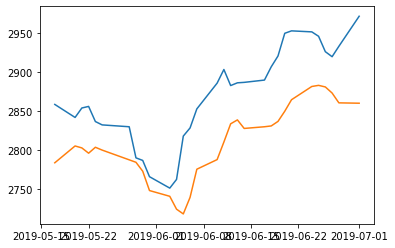

In [18]:
# Step 16: Plot "Open" prediction with the original test "Open"
plt.plot(TestD.loc['2019-05-17':]['Open'])
plt.plot(Pred)
plt.show()

### Step 17: Repeat Steps 11-15 for "FilteredOpen" and "ZeroMeanFilteredOpen" 
Now that we've successfully done predictions using data from "Open", let's work on "FilteredOpen" and "ZeroMeanFilteredOpen" next.

Don't forget that you have to add the FilteredOpen mean to the predictions for ZeroMeanFilteredOpen.

In [19]:
# Step 17a: Set up your model architecture for FilteredOpen, compile, and fit "FilteredOpen" data (Steps 11-12)
modelFO = Sequential()
modelFO.add(LSTM(50, input_shape=(2, 1), return_sequences=True))
modelFO.add(Dropout(0.3))
modelFO.add(LSTM(50))
modelFO.add(Dropout(0.3))
modelFO.add(Dense(1))
modelFO.compile(optimizer='adam', loss='mean_squared_error')
modelFO.fit(X_FO_train, y_FO_train, epochs=15, batch_size=32)

Epoch 1/15
153/153 [==============================] - 4s 4ms/step - loss: 0.2055
Epoch 2/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0171
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 4/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0148
Epoch 5/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0153
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0130
Epoch 7/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0145
Epoch 8/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0129
Epoch 9/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0131
Epoch 10/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 11/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0132
Epoch 12/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0135
Epoch 13/15
153/153 [====

In [20]:
# Step 17b: Transform, loop, transform, and reshape "FilteredOpen" test X data (Step 13)
FOScaledTest=FOScaler.transform(TestD[['FilteredOpen']])
X_FO_Test=[]
y_FO_Test=[]
for i in range(2,len(FOScaledTest)):
  X_FO_Test.append(FOScaledTest[i-2:i,0])
  y_FO_Test.append(FOScaledTest[i,0])
X_FO_Test=np.array(X_FO_Test)
y_FO_Test=np.array(y_FO_Test)
X_FO_Test=X_FO_Test.reshape(X_FO_Test.shape[0], X_FO_Test.shape[1], -1)

# Step 17c: Make the predict method and inverse_transform call (Step 14)
X_FO_Predict=modelFO.predict(X_FO_Test)
X_FO_Predict=FOScaler.inverse_transform(X_FO_Predict)

# Step 17d: Create a DataFrame for your "FilteredOpen" prediction (Step 15)
Pred['FO Pred']=np.squeeze(X_FO_Predict)
Pred

,Open Pred,FO Pred
Date,,
2019-05-17,2783.936035,2807.444824
2019-05-20,2805.458984,2807.087402
2019-05-21,2802.965332,2806.722412
2019-05-22,2796.202393,2805.110596
2019-05-23,2803.789062,2801.004639
2019-05-24,2800.176270,2795.623047
2019-05-28,2787.715332,2789.781250
2019-05-29,2784.582520,2781.520264
2019-05-30,2773.134521,2770.456299


In [21]:
# Step 17e: Set up your model architecture for ZeroMeanFilteredOpen, compile, and fit "ZeroMeanFilteredOpen" data (Steps 11-12)
modelZMFO = Sequential()
modelZMFO.add(LSTM(50, input_shape=(2, 1), return_sequences=True))
modelZMFO.add(Dropout(0.3))
modelZMFO.add(LSTM(50))
modelZMFO.add(Dropout(0.3))
modelZMFO.add(Dense(1))
modelZMFO.compile(optimizer='adam', loss='mean_squared_error')
modelZMFO.fit(X_ZMFO_train, y_ZMFO_train, epochs=15, batch_size=32)

Epoch 1/15
153/153 [==============================] - 3s 5ms/step - loss: 0.1858
Epoch 2/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0177
Epoch 3/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0161
Epoch 4/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0152
Epoch 5/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0148
Epoch 6/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0136
Epoch 7/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0124
Epoch 8/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0139
Epoch 9/15
153/153 [==============================] - 1s 5ms/step - loss: 0.0133
Epoch 10/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0138
Epoch 11/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0132
Epoch 12/15
153/153 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 13/15
153/153 [====

In [22]:
# Step 17f: Transform, loop, transform, and reshape "ZeroMeanFilteredOpen" test X data (Step 13)
ZMFOScaledTest=ZMFOScaler.transform(TestD[['ZeroMeanFilteredOpen']])
X_ZMFO_Test=[]
y_ZMFO_Test=[]
for i in range(2,len(ZMFOScaledTest)):
  X_ZMFO_Test.append(ZMFOScaledTest[i-2:i,0])
  y_ZMFO_Test.append(ZMFOScaledTest[i,0])
X_ZMFO_Test=np.array(X_ZMFO_Test)
y_ZMFO_Test=np.array(y_ZMFO_Test)
X_ZMFO_Test=X_ZMFO_Test.reshape(X_ZMFO_Test.shape[0], X_ZMFO_Test.shape[1], -1)

# Step 17g: Make the predict method and inverse_transform call (Step 14)
X_ZMFO_Predict=modelZMFO.predict(X_ZMFO_Test)
X_ZMFO_Predict=ZMFOScaler.inverse_transform(X_ZMFO_Predict)

# Step 17h: Create a DataFrame for your "ZeroMeanFilteredOpen" prediction (Step 15)
Pred['ZMFO Pred']=np.squeeze(X_ZMFO_Predict)

# Step 17i: Add the FilteredOpen mean (Step 6a) from train DataFrame into all values (reverse the normalization)
Pred['ZMFO Pred']=Pred['ZMFO Pred']+m
Pred

,Open Pred,FO Pred,ZMFO Pred
Date,,,
2019-05-17,2783.936035,2807.444824,2826.286133
2019-05-20,2805.458984,2807.087402,2825.933105
2019-05-21,2802.965332,2806.722412,2825.563477
2019-05-22,2796.202393,2805.110596,2823.930176
2019-05-23,2803.789062,2801.004639,2819.826172
2019-05-24,2800.176270,2795.623047,2814.473145
2019-05-28,2787.715332,2789.781250,2808.639648
2019-05-29,2784.582520,2781.520264,2800.377441
2019-05-30,2773.134521,2770.456299,2789.354492


### Step 18: Plot all three predictions with the original test "Open"
Which predictions did the best? Let's find out by plotting all three sets of predictions on the same plot. 

If your ZeroMeanFilteredOpen plot is way lower than others, make sure you added the mean to undo the zero-mean normalization.

<details>
    <summary><font color = 'green'>SPOILERS! Click once for a look to compare our plot and yours</font></summary>
    <div>
        <img src = 'https://uplevelsg.s3-ap-southeast-1.amazonaws.com/ProjectFinancexLSTM/FinalPredictionPlots.png'>
    </div>
</details>

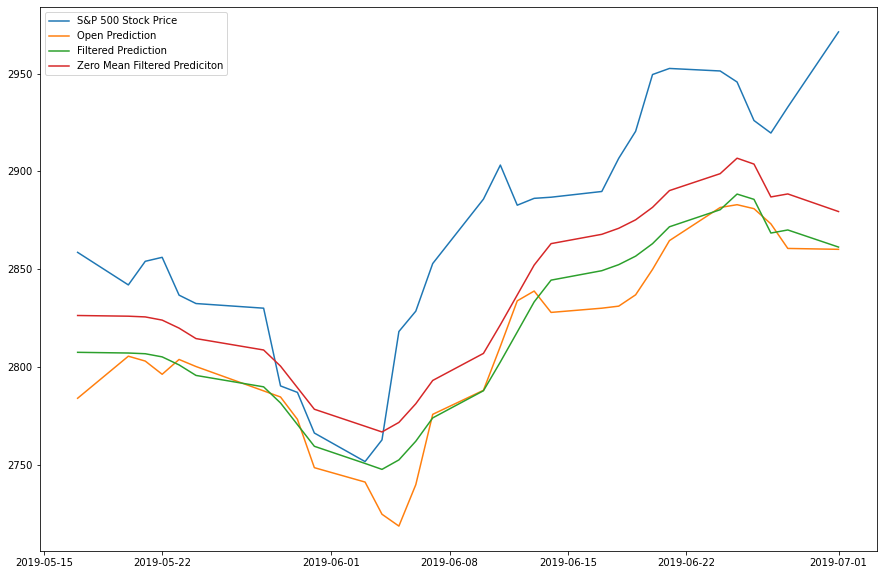

In [23]:
# Step 18: Plot all predictions with the original test "Open"
plt.figure(figsize=(15,10))
plt.plot(TestD.loc['2019-05-17':]['Open'], label='S&P 500 Stock Price')
plt.plot(Pred['Open Pred'], label='Open Prediction')
plt.plot(Pred['FO Pred'], label='Filtered Prediction')
plt.plot(Pred['ZMFO Pred'], label='Zero Mean Filtered Prediciton')
plt.legend()
plt.show()

### Step 19: Calculate the RMSE of the three predictions
Visually, we know which predictions performed best.

However, it's good to put a number on it as well. Let's calculate the RMSE of the predictions.

In [24]:
# Step 19a: Print the RMSE of test 'Open' and 'Open' predictions
print("Open predictions RMSE: ", mean_squared_error(TestD.loc['2019-05-17':]['Open'].values, Pred['Open Pred'].values, squared=False))

# Step 19b: Print the RMSE of test 'Open' and 'FilteredOpen' predictions
print("Filtered open predictions RMSE: ", mean_squared_error(TestD.loc['2019-05-17':]['Open'].values, Pred['FO Pred'].values, squared=False))

# Step 19c: Print the RMSE of test 'Open' and 'ZeroMeanFilteredOpen' predictions
print("Zero mean filtered open predictions RMSE: ", mean_squared_error(TestD.loc['2019-05-17':]['Open'].values, Pred['ZMFO Pred'].values, squared=False))

Open predictions RMSE:  65.69300255324468
Filtered open predictions RMSE:  59.16124154347281
Zero mean filtered open predictions RMSE:  43.31456970985568


# The end
And that's the end! What a journey; you successfully performed classical and deep learning for S&P 500 stock prices.

To recap, you've:
1. Read research on stock pricing and retrieved the data
2. Investigated the ARIMA terms and performed ARIMA modelling
3. Used signal processing techniques to denoise stock data
4. Trained an LSTM model to predict stock pricing data

You have also answered the two questions that we wanted to ask at the start of this project.

Go on, give yourself a pat on the back. We hope this project series has give you more confidence in coding and deep learning. 

Whatever you learn here is but a tip of the iceberg, and launchpad for bigger and better things to come. 

If you're keen, here are some more things you can try:
- More datasets, e.g., HSI and DJI
- More modelling, e.g., more complex LSTM infrastructures

Come join us in our Telegram community over at https://bit.ly/UpLevelSG and our Facebook page at https://fb.com/UpLevelSG

<strong>Most importantly, UpLevel won't be what it is today without learners like yourself so help us grow by spreading the word and get more subscribers <font color = 'red'><3</font></strong>
